In [1]:
import random

In [ ]:
full_dataset_time = 15 * 65 / 60 / 0.7
full_dataset_time

23.214285714285715

In [3]:
total_dataset_value = 0.3 + 0.4 + 0.5 + 0.6 + 0.7
total_dataset_value

2.5

In [4]:
full_dataset_time * 0.3

6.964285714285714

In [5]:
total_dataset_value * full_dataset_time / 24

2.4181547619047623

In [6]:
import csv


def find_max_map(file_path):
    with open(file_path, mode="r", newline="") as csvfile:
        reader = csv.reader(x.replace("\0", "") for x in csvfile)
        header = next(reader)  # Read the header
        # Find the index of the 'metrics/mAP50-95(B)' column (8th column, zero-indexed as 7)
        map_column_index = 7

        # Initialize max value
        max_map_value = float("-inf")

        # Iterate over the rows and find the max value
        for row in reader:
            try:
                # Convert the value to float and update max_map_value if current value is higher
                map_value = float(row[map_column_index].strip())
                max_map_value = max(max_map_value, map_value)
            except ValueError:
                # Handle cases where conversion to float fails (e.g., empty or non-numeric values)
                continue

        return max_map_value


# Example usage:
# max_value = find_max_map('your_file.csv')
# print("Max mAP50-95(B):", max_value)

In [7]:
find_max_map("/home/setupishe/ultralytics/runs/detect/confidences_0.3/results.csv")

0.44705

In [8]:
find_max_map("/home/setupishe/ultralytics/runs/detect/random_0.3/results.csv")

0.45295

In [44]:
actives = [
    find_max_map(f"/home/setupishe/ultralytics/runs/detect/random_{0.2}/results.csv")
]
randoms = [actives[0]]
fractions = ["0.2"]

In [45]:
for i in range(3, 8):
    fraction = f"0.{i}"
    active_path = (
        f"/home/setupishe/ultralytics/runs/detect/active_{fraction}/results.csv"
    )
    random_path = (
        f"/home/setupishe/ultralytics/runs/detect/random_{fraction}/results.csv"
    )
    actives.append(find_max_map(active_path))
    randoms.append(find_max_map(random_path))
    fractions.append(fraction)

In [46]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'mAP@.5:.95')

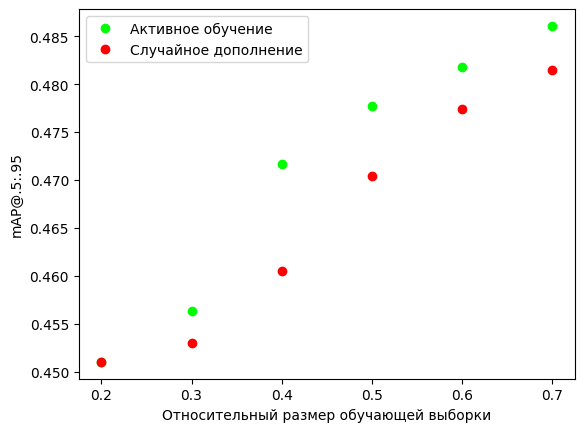

In [49]:
plt.plot(fractions, actives, marker="o", lw=0, c=[0, 1, 0], label="Активное обучение")
plt.plot(
    fractions, randoms, marker="o", lw=0, c=[1, 0, 0], label="Случайное дополнение"
)
plt.legend()
plt.xlabel("Относительный размер обучающей выборки")
plt.ylabel("mAP@.5:.95")

In [3]:
find_max_map("/home/setupishe/ultralytics/runs/detect/active_0.7/results.csv")

0.48608

In [4]:
find_max_map("/home/setupishe/ultralytics/runs/detect/random_0.7/results.csv")

0.48149

In [2]:
import os, glob, shutil

In [3]:
from PIL import Image

In [4]:
import cv2

In [5]:
def get_shape(img_path):
    with Image.open(img_path) as img:
        width, height = img.size
    return height, width

In [6]:
from tqdm import tqdm

In [7]:
def force_mkdir(directory):
    if os.path.isdir(directory):
        shutil.rmtree(directory)
    os.mkdir(directory)

In [5]:
with open("/home/setupishe/datasets/coco/train2017_0.2.txt", "r") as f:
    lines = f.readlines()

In [6]:
names = [os.path.basename(x)[:-1] for x in lines]

In [9]:
folder_name = "imgs_0.2"

In [10]:
force_mkdir(folder_name)

In [8]:
def get_shape(img_path):
    with Image.open(img_path) as img:
        width, height = img.size
    return height, width

In [9]:
def txt2jpg(inp):
    return inp.replace("/labels", "/images").replace(".txt", ".jpg")

In [10]:
def seg2bbox(filepath, to_path):
    with open(filepath, "r") as f:
        lines = [x.rstrip("\n") for x in f.readlines()]
    new_lines = []
    for line in lines:
        lst = line.split()
        new_line = [lst[0]]

        coords = [float(x) for x in lst[1:]]
        h, w = get_shape(txt2jpg(filepath))
        first = [x for i, x in enumerate(coords) if i % 2 == 0]
        second = [x for i, x in enumerate(coords) if i % 2 == 1]
        for i in range(len(first)):
            first[i] = int(first[i] * w)
            second[i] = int(second[i] * h)

        xmin = min(first)
        xmax = max(first)
        ymin = min(second)
        ymax = max(second)

        width = (xmax - xmin) / w
        height = (ymax - ymin) / h
        xc = (xmax + xmin) / w / 2
        yc = (ymax + ymin) / h / 2

        new_lines.append(
            " ".join([str(item) for item in [lst[0], xc, yc, width, height]]) + "\n"
        )
    with open(to_path, "w") as f:
        f.writelines(new_lines)

In [12]:
filelist = glob.glob("/home/setupishe/datasets/coco/images/train2017/*jpg")
for file in tqdm(filelist):
    label_file = file.replace("images", "labels").replace("jpg", "txt")
    if os.path.exists(label_file):
        seg2bbox(label_file, file.replace("jpg", "txt"))
    else:
        os.mknod(file.replace("txt"))

  0%|          | 0/118287 [00:00<?, ?it/s]

100%|██████████| 118287/118287 [01:10<00:00, 1677.78it/s]


### remainder embeds

In [33]:
folder_name = "remainder_imgs_0.2"

In [34]:
force_mkdir(folder_name)

In [35]:
filelist = glob.glob("/home/setupishe/datasets/coco/images/train2017/*jpg")
for file in tqdm(filelist):
    if os.path.basename(file) not in names:
        shutil.copy(file, os.path.join(folder_name, os.path.basename(file)))
        label_file = file.replace("images", "labels").replace("jpg", "txt")
        if os.path.exists(label_file):
            seg2bbox(
                label_file, os.path.join(folder_name, os.path.basename(label_file))
            )
        else:
            os.mknod(label_file)

100%|██████████| 118287/118287 [01:48<00:00, 1090.82it/s]


запускаем `produce_detection_embeddings.py`

запускаем `preprocess_embedding_pool.py`

In [2]:
for file in glob.glob("remainder_embeds_reduced_0.2/**/*npy", recursive=True):
    if len(os.path.basename(file).split("_")) == 2:
        os.remove(file)

In [ ]:
for file in glob.glob("rembeds_reduced_0.2/**/*npy", recursive=True):
    if len(os.path.basename(file).split("_")) == 2:
        os.remove(file)

запускаем `testing_embeds.ipynb`

In [26]:
uniq = set()
for file in os.listdir("test_folder"):
    uniq.add(file.split("_")[0])

In [27]:
len(uniq)

13332

In [36]:
target_num = 118287 * 0.1

In [37]:
not_bgs = [x + ".jpg" for x in random.sample(list(uniq), int(target_num * (1 - 0.008)))]

ищем свободные не использованные фоны

In [38]:
from tqdm import tqdm

In [39]:
free_bgs = []

In [40]:
for file in tqdm(
    glob.glob("/home/setupishe/datasets/coco/labels/train*/**/*txt", recursive=True)
):
    name = os.path.basename(file)
    if not os.path.getsize(file) and name not in names:
        free_bgs.append(file)

100%|██████████| 118287/118287 [00:00<00:00, 399844.65it/s]


In [41]:
bgs = [
    os.path.basename(x).replace("txt", "jpg")
    for x in random.sample(free_bgs, int(target_num * 0.008))
]

In [42]:
with open("/home/setupishe/datasets/coco/train2017_0.3_active.txt", "w") as f:
    f.writelines([f"./images/train2017/{x}\n" for x in names + not_bgs + bgs])

In [1]:
int_frac = 0.4

In [2]:
with open(
    "/home/setupishe/ultralytics/ultralytics/cfg/datasets/coco.yaml", "r"
) as from_file:
    lines = from_file.readlines()

for i, line in enumerate(lines):
    if "train: train2017.txt" in line:
        lines[i] = lines[i].replace("train2017.txt", f"train2017_{int_frac}_active.txt")
with open(
    f"/home/setupishe/ultralytics/ultralytics/cfg/datasets/coco_{int_frac}_active.yaml",
    "w",
) as to_file:
    to_file.writelines(lines)